In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
import pandas as pd
from pandas import Series, DataFrame

#Intro, overview

##Why the complexity of Pandas's groupby and MultiIndex, when SQL is simpler?

Per the intro, the complexity of pandas syntax and MultiIndex use is ok because 'query languages like SQL are rather limited in the kinds of group operations that can be performed'. Pandas supports 'much more complex grouped operations by utilizing any function that accepts a pandas object or NumPy array.'

For example, rather than just specifying the names of columns to define how to group, pandas lets you define your group (the keys) in terms of DataFrame column names, arrays, or functions (i.e., in code). Once you have a set of groups, you can compute things - like count, mean, etc. using pre-defined function, or define your own functions.

##Mechanics - split, apply, combine

All group by work can be thought of as having three parts:
1. Split - Data (in a Series, DataFrame, etc.) is split into groups based on one or more keys. SQL splits data into groups by row - i.e., the groups are made up of one or more rows. In Pandas this is splitting by axis = 0. Pandas can also group by/split columns, with axis = 1.
2. Apply - A function is applied to each group, producing a new value. For example, 'count' - or is it just 'size'? - can be applied to count the number of rows (or columns, if splitting by axis = 1), sum can be applied to sum values associated with each row in the group, etc.
3. Combine - Finally, the results of the apply step are combined into a result object. The book says taht the 'resulting object will usually depend on what's being done to the data' - I'm not sure what this means; hopefully it'll become clear after working through the chapter.

#Split - defining keys

Ultimately you want a set of one or more grouping keys. You can provide explicitly a list or array of values that is the same length as the axis being grouped (for ex, if you're grouping rows then you provide a list w/ values where the length of the list is equal to the number of rows). Or you can provide other stuff, as shown below, that are each and all shortcuts to define a list of values that's the same length as the axis being grouped.

In [44]:
df = DataFrame({'key1': list('aabba'),
                'key2': 'one two one two one'.split(),
                'data1': np.random.randn(5),
                'data2': np.random.randn(5)})
df

,data1,data2,key1,key2
0,-1.142105,-0.427882,a,one
1,0.143537,0.052476,a,two
2,-0.295989,0.101438,b,one
3,-1.844569,0.606259,b,two
4,1.526356,-1.167850,a,one


As one example - which one, I'll need to think through or learn - here we first get a Series object for the 'data1' column. Then we group that Series object using values from the 'key1' column. I think this means we're working with two Series instances - one that has the data we care about working with, on which we call the groupby method, and one that provides the values that groupby needs to actually group the original values.

In [27]:
grouped = df['data1'].groupby(df['key1'])
grouped

Once we have this SeriesGroupBy object, which I think represents the groups but not the apply part of the steps above - i.e., it's just doing the split part, then we can actually do the 'apply' by applying a function to the groupby.

In [28]:
grouped.mean()

key1
a   -0.366095
b    0.423272
Name: data1, dtype: float64

When we apply a function like mean we turn a Series into another Series, where the produced/second Series has a row for each unique value specified by the key. Here the key is only made up of the key1 column, and the key1 column has two unique values, so the resulting Series has two rows - further, the index values for these two rows are the unique values. The actual data associated with each row is the result of the function we applied to the SeriesGroupBy object, which is 'mean' in this case.

Another example involves passing multiple arrays as a list.

In [29]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one    -0.179601
      two    -0.739081
b     one     1.237260
      two    -0.390717
Name: data1, dtype: float64

The above is the same as the first example, except that we group by two Series. We get a MultiIndex where the first level is the unique values of the first key, and the second level is the unique values of the second key. 

In [30]:
means.unstack()

key2,one,two
key1,,
a,-0.179601,-0.739081
b,1.237260,-0.390717


The next example was a bit odd to me, because it shows the use of arrays w/ any content, as long as they're the 'right' length, where 'right' means the same length as the axis we're grouping. Based on checking the values of the actual calculated means, it looks like the _location_ of the key values is what matters... the actual key values themselves aren't important to figure out which rows in the source are grouped... they're only used as the labels for the index in the resulting groupby and DataFrame. That is, in the following example, 'Ohio' and 2005 are at location 0, so the row in the source data at location 0 is made a part of the group with keys 'Ohio' and 2005. Location three also has the same key values, so it's made part of the same group. The other locations have different key values.

Upon a bit of reflection, this makes sense - all groupby really cares about is a set of values, one for each entity (row, or column) being grouped - it creates groups of entities where each group is just made of entities with the same key value. The key value can come from anywhere, including as an array that's defined completely separately from anything we're grouping. (Although that's not common, I think.)

In [31]:
states = np.array(['Ohio','California','California','Ohio','Ohio'])
years = np.array([2005,2005,2006,2005,2006])

df['data1'].groupby([states, years]).mean()

California  2005   -0.739081
            2006    1.237260
Ohio        2005   -0.500794
            2006    0.251667
Name: data1, dtype: float64

In all of the above examples we used individual Series instances on which to call groupby and to provide the key(s). There was no relationship needed between the two. 

Another option, if the grouping information is in the same DataFrame as the data being grouped, all you need to do is specify the name of the column(s).

In [32]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.366095,-0.167894
b,0.423272,1.046002


Note that in the previous example, there's no 'key2' column in the results, even though we're not grouping by it and it's in the source data frame. This is because by default any columns that have non-numeric data are considered 'nuisance' columns (at least when you do the apply w/ a function - like mean - that requires numeric data?) and so left out of the result.

In [33]:
df.groupby(['key1','key2']).mean()

data1     data2
key1 key2                    
a    one  -0.179601 -0.912420
     two  -0.739081  1.321158
b    one   1.237260  0.894614
     two  -0.390717  1.197390

In [34]:
# don't forget that to just get a count of rows/items in the group
# use 'size' (NOT 'count')
df.groupby(['key1','key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

##Iterating over groups

When you have a groupby object - you haven't applied the 'apply' function yet - you can still do interesting stuff with, including iterating through things (rows, or columns) that were grouped.

In [35]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
      data1     data2 key1 key2
0 -0.610870 -1.384503    a  one
1 -0.739081  1.321158    a  two
4  0.251667 -0.440337    a  one
b
      data1     data2 key1 key2
2  1.237260  0.894614    b  one
3 -0.390717  1.197390    b  two


In [36]:
for (k1, k2), group in df.groupby(['key1','key2']):
    print(k1, k2)
    print(group)

a one
      data1     data2 key1 key2
0 -0.610870 -1.384503    a  one
4  0.251667 -0.440337    a  one
a two
      data1     data2 key1 key2
1 -0.739081  1.321158    a  two
b one
     data1     data2 key1 key2
2  1.23726  0.894614    b  one
b two
      data1    data2 key1 key2
3 -0.390717  1.19739    b  two


A useful recipe is 'computing a dict of the data pieces [i.e., the 'group' part of the tuples returned by groupby) as a one-liner':

In [45]:
pieces = dict(list(df.groupby('key1')))
len(pieces) # 2, because we had two groups, with keys 'a' and 'b'

2

In [38]:
pieces

{'a':       data1     data2 key1 key2
 0 -0.610870 -1.384503    a  one
 1 -0.739081  1.321158    a  two
 4  0.251667 -0.440337    a  one, 'b':       data1     data2 key1 key2
 2  1.237260  0.894614    b  one
 3 -0.390717  1.197390    b  two}

In [39]:
pieces['b']

,data1,data2,key1,key2
2,1.237260,0.894614,b,one
3,-0.390717,1.197390,b,two


##Example of grouping columns instead of rows

In [40]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [41]:
grouped_cols = df.groupby(df.dtypes, axis=1)
grouped_cols

In [42]:
dict(list(grouped))

{'a': 0   -0.610870
 1   -0.739081
 4    0.251667
 Name: data1, dtype: float64, 'b': 2    1.237260
 3   -0.390717
 Name: data1, dtype: float64}

##Selecting a column or subset of columns

With no further code, the apply method is used on each (non-numeric) column. We can also specify only selected columns.

In [47]:
df.groupby('key1')['data1'].sum()

key1
a    0.527789
b   -2.140557
Name: data1, dtype: float64

The above is syntactic sugar for what's really happening:

In [48]:
df['data1'].groupby(df['key1']).sum()

key1
a    0.527789
b   -2.140557
Name: data1, dtype: float64

Also - and I think this is cool and that it's about time I finally figured it out - if you pass a list to the DataFrame indexing/bracket operator, you get back a DataFrame instead of a Series (which, of course, is what you get when you specify a single string). This looks odd when you pass only a single column name, but doesn't look so odd when you pass multiple column names - the single column name is doing the same thing, so it's consistent, even if it does look odd. 

In [49]:
type(df['data1']) # Series, as we know

pandas.core.series.Series

In [54]:
type(df[['data1','data2']]) # DataFrame, since we have two columns

pandas.core.frame.DataFrame

In [55]:
type(df[['data1']]) # Still a DataFrame, since we passed a list - only one column though

pandas.core.frame.DataFrame

So, back to grouping, and another example of syntactic sugar. Both of the following are the same.

In [56]:
df.groupby('key1')[['data2']].sum()

,data2
key1,
a,-1.543256
b,0.707696


In [58]:
df[['data2']].groupby(df['key1']).sum()

,data2
key1,
a,-1.543256
b,0.707696


Another example - filtering to only a few cols 'may be especially useful for large datasets.

In [59]:
df.groupby(['key1','key2'])[['data2']].mean()

data2
key1 key2          
a    one  -0.797866
     two   0.052476
b    one   0.101438
     two   0.606259

In [60]:
# above is same as
df[['data2']].groupby([df['key1'], df['key2']]).mean()

data2
key1 key2          
a    one  -0.797866
     two   0.052476
b    one   0.101438
     two   0.606259

The nature of the object that comes back from the groupby (before the operation is applied) depends on if you pass a single column name - you get a 'grouped Series' - or if you pass a list or arry - you get a 'grouped DataFrame'. 

In [62]:
s_grouped = df.groupby(['key1','key2'])['data2']
s_grouped

In [64]:
df_grouped = df.groupby(['key1','key2'])[['data2']]
df_grouped

In [67]:
df_grouped = df.groupby('key1 key2'.split())[['data1','data2']]
df_grouped

##Grouping with dicts and Series

You don't need to have your grouping information in a list or array.

In [69]:
people = DataFrame(np.random.randn(5,5),
                   columns=list('abcde'),
                   index='Joe Steve Wes Jim Travis'.split())
people.ix[2:3, ['b','c']] = np.nan
people

,a,b,c,d,e
Joe,0.180718,0.602803,-2.505254,-0.585075,2.018985
Steve,0.313131,0.595180,-0.223885,-0.853578,1.731554
Wes,-0.660761,NaN,NaN,2.328535,0.600022
Jim,-0.357893,0.164575,0.987413,0.715731,0.341701
Travis,0.479686,-0.866455,-1.169262,-1.457515,-0.909903


In [70]:
# consider this a 'group correspondence' - each column above maps
# to a color, defined by this dict.
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f': 'orange'}
mapping

{'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

Here, groupby works by column - I think it takes the label on each column - a, b, etc. - and uses the dict to map the label to the actual grouping key, so 'a' is mapped to 'red', and 'red' is used as the grouping key.

In [73]:
by_column = people.groupby(mapping, axis=1)
by_column.sum()

,blue,red
Joe,-3.090329,2.802506
Steve,-1.077463,2.639865
Wes,2.328535,-0.060738
Jim,1.703144,0.148382
Travis,-2.626778,-1.296672


In [74]:
map_series = Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

You can also map using a Series, 'which can be viewed as a fixed-size mapping'.

In [75]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


##Grouping with functions

Or,  you can pass a function, which will be called once per entity being grouped, and whose return value will be used as the grouping key.

For example, the following calls len for each row - each index value is what's actually passed, which here is the name - and the return value of the function is used to group. For example, 'Joe' has three letters, as does 'Wes' and 'Jim', so those three rows are grouped together into a single group. Applying sum adds the values for those three rows, and the returned DataFrame has a row with an index value of 3.

In [77]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.837936,0.767377,-1.517841,2.459190,2.960708
5,0.313131,0.595180,-0.223885,-0.853578,1.731554
6,0.479686,-0.866455,-1.169262,-1.457515,-0.909903


You can mix functions, dicts, and Series - everything gets converted to arrays internally. I think that means the ultimately there's an array of key values, regardless of where it comes from.

I think this means that the next example is grouping by two key values - first by the number returned by len, and then by the set of key values in the passed list (i.e., here, by grouping the first three rows and then the second two rows).

In [79]:
key_list = 'one one one two two'.split()
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.660761  0.602803 -2.505254 -0.585075  0.600022
  two -0.357893  0.164575  0.987413  0.715731  0.341701
5 one  0.313131  0.595180 -0.223885 -0.853578  1.731554
6 two  0.479686 -0.866455 -1.169262 -1.457515 -0.909903

##Grouping with index levels

If you have a hierarchical index, you can group using one (or more?) of the levels of the index, by passing the level number or name using the level keyword.

In [80]:
columns = pd.MultiIndex.from_arrays(['US US US JP JP'.split(),
                                    [1,3,5,1,3]],
                                    names=['cty','tenor'])
columns

MultiIndex(levels=[['JP', 'US'], [1, 3, 5]],
           labels=[[1, 1, 1, 0, 0], [0, 1, 2, 0, 1]],
           names=['cty', 'tenor'])

In [82]:
hier_df = DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -1.052541  0.598300  0.715088 -0.309342 -0.794973
1     -0.709837  0.118723  0.336335  0.114131  0.713223
2      0.631868  0.363225  1.324010  0.440500 -0.222555
3      0.865379 -2.176058  0.860176 -0.494471 -0.327906

In [83]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


#Data aggregation

Here 'aggregation' means any transformation of data that produces scalar values from arrays - mean, count, min, sum, etc.

You can use these, or call other methods that are defined on the groupby object, or write your own.

In [84]:
df

,data1,data2,key1,key2
0,-1.142105,-0.427882,a,one
1,0.143537,0.052476,a,two
2,-0.295989,0.101438,b,one
3,-1.844569,0.606259,b,two
4,1.526356,-1.167850,a,one


In [88]:
grouped = df.groupby('key1')
grouped.size()

key1
a    3
b    2
dtype: int64

Difference between count and size? It looks like size is meant to return the 'size of the group', which I take to be the number of entities (rows, columns) grouped using each key value. Accordingly, you'd expect a series (at least if you group by just one key value?) with one row per unique key value, and that's what we see above.

The count method instead is just something that you can apply to each column? As below.

It might be that count and size treat NAs differently? Would be interesting to investigate if it matters.

In [89]:
grouped.count()

,data1,data2,key2
key1,,,
a,3,3,3
b,2,2,2


If we group by multiple keys and then call size and count, what do we get?

In [90]:
df.groupby(['key1','key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

So, we, still get a series from size, but now it has a hierarchical index, and individual size of each group identified by each unique combination of key values.

In [91]:
df.groupby(['key1','key2']).count()

data1  data2
key1 key2              
a    one       2      2
     two       1      1
b    one       1      1
     two       1      1

We don't have to only call GroupBy methods - if we have a SeriesGroupBy object, we can call any method defined for a Series, I think.

In [92]:
grouped

In [93]:
grouped['data1'] # this is a SeriesGroupBy

The quantile method is defined on Series, so we'll try it here, applied to each group. "Internally, GroupBy efficiently slices up the Series, calls piece.quantile(0.9) for each piece" - where a 'piece' is a group with a common key value, I think - "and then assembles those results together into the result object."

In [94]:
grouped['data1'].quantile(0.9)

key1
a    1.249792
b   -0.450847
Name: data1, dtype: float64

In [96]:
Series.quantile?

In [100]:
Series([-0.295989, -1.844569]).quantile(0.9)

-0.450847

Your, use your own aggregation functions by passing any function that aggregates an array to the aggregate or agg method.

In [101]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.668461,1.220325
b,1.548580,0.504821


The book says that 'describe' isn't an aggregation, 'strictly speaking', but still works. It's called on each group.

In [103]:
grouped.describe()

data1     data2
key1                          
a    count  3.000000  3.000000
     mean   0.175930 -0.514419
     std    1.334525  0.614748
     min   -1.142105 -1.167850
     25%   -0.499284 -0.797866
     50%    0.143537 -0.427882
     75%    0.834947 -0.187703
     max    1.526356  0.052476
b    count  2.000000  2.000000
     mean  -1.070279  0.353848
     std    1.095011  0.356963
     min   -1.844569  0.101438
     25%   -1.457424  0.227643
     50%   -1.070279  0.353848
     75%   -0.683134  0.480054
     max   -0.295989  0.606259

##More advanced, using restaurant tipping dataset

In [104]:
tips = pd.read_csv('../pydata-book/ch08/tips.csv')
len(tips)

244

In [105]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [106]:
# add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


In [107]:
tips.describe()

,total_bill,tip,size,tip_pct
count,244.000000,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672,0.160803
std,8.902412,1.383638,0.951100,0.061072
min,3.070000,1.000000,1.000000,0.035638
25%,13.347500,2.000000,2.000000,0.129127
50%,17.795000,2.900000,2.000000,0.154770
75%,24.127500,3.562500,3.000000,0.191475
max,50.810000,10.000000,6.000000,0.710345


In [108]:
tips[tips['tip_pct'] > 0.5]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


Let's look at tips by sex and smoking status.

In [109]:
grouped = tips.groupby(['sex', 'smoker'])

In [110]:
grouped_tip_pct = grouped['tip_pct']
grouped_tip_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [111]:
grouped_tip_pct.mean()

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [112]:
# apply multiple functions
grouped_tip_pct.agg(['mean','std',peak_to_peak])

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

In [114]:
# provide a name isntead of using the function name (helpful for lambdas)
grouped_tip_pct.agg([('foo','mean'), ('bar', np.std)])

foo       bar
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

DataFrames provide more options - you can provide a list of functions to apply to all of the columns, or different functions to different columns.

In [115]:
functions = ['count','mean','max']
result = grouped['tip_pct','total_bill'].agg(functions)
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

In [116]:
result['tip_pct']

count      mean       max
sex    smoker                           
Female No         54  0.156921  0.252672
       Yes        33  0.182150  0.416667
Male   No         97  0.160669  0.291990
       Yes        60  0.152771  0.710345

There's a few more examples in the book, on p263 and the top of p264.

##Return aggregated data in 'unindexed' form

Up to this point the aggregated data always comes back with an index made up of the unique group key combinations that exist in the data. If you group by multiple keys, you get a hierarchical index.

You can disable this, and get back a DataFrame, using as_index=False.

In [117]:
tips.groupby(['sex','smoker'], as_index=False).mean()

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


In [118]:
# compare to
tips.groupby(['sex','smoker']).mean()

total_bill       tip      size   tip_pct
sex    smoker                                          
Female No       18.105185  2.773519  2.592593  0.156921
       Yes      17.977879  2.931515  2.242424  0.182150
Male   No       19.791237  3.113402  2.711340  0.160669
       Yes      22.284500  3.051167  2.500000  0.152771

Or, you can take the returned DataFrame with the hierarchical index and convert it to the as_index=False format, using reset_index(). (DataFrame.reset_index? says 'For DataFrame with multi-level index, return new DataFrame with labeling information in the columns under the index names..').

In [121]:
tips.groupby(['sex','smoker']).mean().reset_index()

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


#Group-wise operations and transformations

Aggregation is a special case of general data transformations - instead of just reducing one-dimensional arrays to scalar values, you can do other things too.

For example, to add a column to a DataFrame containing group means for each index - you can do this via aggregating, then merging, which 'works, but is inflexible'.

In [122]:
df

,data1,data2,key1,key2
0,-1.142105,-0.427882,a,one
1,0.143537,0.052476,a,two
2,-0.295989,0.101438,b,one
3,-1.844569,0.606259,b,two
4,1.526356,-1.167850,a,one


In [126]:
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

,mean_data1,mean_data2
key1,,
a,0.175930,-0.514419
b,-1.070279,0.353848


In [127]:
pd.merge(df, k1_means, left_on='key1', right_index=True)

,data1,data2,key1,key2,mean_data1,mean_data2
0,-1.142105,-0.427882,a,one,0.175930,-0.514419
1,0.143537,0.052476,a,two,0.175930,-0.514419
4,1.526356,-1.167850,a,one,0.175930,-0.514419
2,-0.295989,0.101438,b,one,-1.070279,0.353848
3,-1.844569,0.606259,b,two,-1.070279,0.353848


Conceptually, what we did above is to 'transform the two data columns using the np.mean function'.

Using a different DataFrame...

In [128]:
people

,a,b,c,d,e
Joe,0.180718,0.602803,-2.505254,-0.585075,2.018985
Steve,0.313131,0.595180,-0.223885,-0.853578,1.731554
Wes,-0.660761,NaN,NaN,2.328535,0.600022
Jim,-0.357893,0.164575,0.987413,0.715731,0.341701
Travis,0.479686,-0.866455,-1.169262,-1.457515,-0.909903


In [129]:
key = 'one two one two one'.split()
people.groupby(key).mean()

,a,b,c,d,e
one,-0.000119,-0.131826,-1.837258,0.095315,0.569701
two,-0.022381,0.379878,0.381764,-0.068924,1.036627


In [132]:
Series([0.180718, -0.660761, 0.479686]).mean()

-0.00011900000000001724

In [133]:
Series([0.313131, -0.357893]).mean()

-0.022381000000000012

In [130]:
people.groupby(key).transform(np.mean)

,a,b,c,d,e
Joe,-0.000119,-0.131826,-1.837258,0.095315,0.569701
Steve,-0.022381,0.379878,0.381764,-0.068924,1.036627
Wes,-0.000119,-0.131826,-1.837258,0.095315,0.569701
Jim,-0.022381,0.379878,0.381764,-0.068924,1.036627
Travis,-0.000119,-0.131826,-1.837258,0.095315,0.569701


So, I think what's going on above is that the rows are grouped first, then the passed function - np.mean here - is applied to the values associated with the grouped rows. Then, here's the difference w/ 'transform', instead of just returning the values - as the mean function above shows - the results are instead, since the result is a scalar value, broadcasted to each row that's a part of the group. So, the -0.000119 values is used for rows 0, 2, and 4.

That's the behavior when the function returns a scalar value. If the function returns... TBD

In [134]:
def demean(arr):
    return arr - arr.mean()

I think applying demean to a Series like below calculates the mean for each row - i.e., each value - and so the mean is the same as the actual value. Subtracting this 'mean' from the value of course gives zero.

In [140]:
Series([3, 5, 7]).map(demean)

0    0
1    0
2    0
dtype: float64

What we instead want to do is call demean on a group - to calculate the mean of the group - and subtract that mean value from each individual value in the group. Given the same 'demean' function defined above, the following code, using transform, does this.

In [139]:
people.groupby(key).transform(demean)

,a,b,c,d,e
Joe,0.180837,0.734629,-0.667996,-0.680390,1.449284
Steve,0.335512,0.215303,-0.605649,-0.784654,0.694927
Wes,-0.660642,NaN,NaN,2.233220,0.030321
Jim,-0.335512,-0.215303,0.605649,0.784654,-0.694927
Travis,0.479805,-0.734629,0.667996,-1.552830,-1.479605


In [146]:
people['a']

Joe       0.180718
Steve     0.313131
Wes      -0.660761
Jim      -0.357893
Travis    0.479686
Name: a, dtype: float64

In [148]:
# to check, the second group is rows 1 and 3 - these values are from 
# the data above, not the demeaned results 
m = Series([0.313131, -0.357893]).mean()
m

-0.022381000000000012

These manually calculated values match the values in the demeaned DataFrame above - see rows 1 and 3 (Steve and Jim). 

In [151]:
print(0.313131 - -0.022381)
print(-0.357893 - -0.022381)

0.335512
-0.33551200000000003


#Apply: general split-apply-combine

The transform method shown immediately previous is a bit like the aggregate method: they're both specialized routines with more rigid requirements. In the case of transform, the passed function must either return a scalar value (that will be broadcasted to all of the rows/columns, like np.mean), or a transformed array that's the same size as the number of rows/columns.

The more general version of transform is called apply. The apply method splits the object into pieces, invokes the passed function on each piece, and then concatenates the resulting pieces together.

To get the top five tip_pct values per group...

In [152]:
# return the rows w/ the largest values in a given column
def top(df, n=5, column='tip_pct'):
    return df.sort_index(by=column)[-n:]

In [153]:
top(tips, n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


To find the top tips, divided by smoking status, group by smoking status and then use apply w/ the top method. Pandas first produces two groups w/ 'no' and 'yes' key values, and then calls the top method on each group, and then concatenates the results back together (adding a new top-level hierarchical index with the values from the group.)

In [154]:
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

In [155]:
# you can pass additional args to your function like so
tips.groupby(['smoker','day']).apply(top, n=1, column='total_bill')

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

We previously did the following, with describe, even though describe isn't really a classic aggregation function. What happened?

In [161]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
dtype: float64

In [162]:
result.unstack('smoker')

smoker,No,Yes
count,151.000000,93.000000
mean,0.159328,0.163196
std,0.039910,0.085119
min,0.056797,0.035638
25%,0.136906,0.106771
50%,0.155625,0.153846
75%,0.185014,0.195059
max,0.291990,0.710345


Per page 268, invoking describe like we did above actually does something like the following:

    f = lambda x: x.describe()
    grouped.apply(f)
    
So, first Pandas groups by smoking status, then Pandas calls the passed method on each piece.

In [163]:
# kind of like with groupby and as_index=False used w/ things like 
# aggregation above, I think, we can use group_keys=False to turn off
# the hierarchical index formed using the group keys
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [164]:
# compare above to
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

#More examples showing how to use groupby to do common stuff

##Quantile and bucket analysis

In [171]:
frame = DataFrame({'data1': np.random.randn(1000),
                   'data2': np.random.randn(1000)})
frame.tail()

,data1,data2
995,-0.765182,-1.229721
996,0.357403,0.723729
997,-0.448118,-0.353863
998,-0.624614,-0.550913
999,-0.200699,1.448630


In [172]:
# I think this creates four equally sized bins (_not_ bins with equal
# numbers of elements), and then returns the bin into which each value
# values
factor = pd.cut(frame.data1, 4)
factor[:10]

0    (-1.639, -0.0966]
1     (-0.0966, 1.445]
2     (-0.0966, 1.445]
3    (-1.639, -0.0966]
4     (-0.0966, 1.445]
5       (1.445, 2.987]
6     (-0.0966, 1.445]
7    (-1.639, -0.0966]
8     (-0.0966, 1.445]
9       (1.445, 2.987]
Name: data1, dtype: category
Categories (4, object): [(-3.187, -1.639] < (-1.639, -0.0966] < (-0.0966, 1.445] < (1.445, 2.987]]

Now that we have a bucket to which each value in our DataFrame belongs - it's an array of the same length as our frame - we can pass that the list of buckets to groupby in order to group all of the rows into four groups. Then we can do things w/ those four groups, like calculate stuff using the data2 column.

In [173]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
grouped = frame.data2.groupby(factor)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.187, -1.639]",43,1.529195,0.078487,-2.692486
"(-1.639, -0.0966]",373,2.497762,0.054034,-2.869815
"(-0.0966, 1.445]",508,2.595553,-0.037902,-3.701409
"(1.445, 2.987]",76,3.243109,-0.044808,-2.229166


As noted above, the buckets were equal-sized, since we used pd.cut. For buckets that contain equal numbers of elements, we use pd.qcut.

In [186]:
# looks like labels=False makes qcut return the index of the bucket - 
# here, between 0 and 9 - instead of labels that look like what we
# got from cut (such as  (1.282, 2.987]). i guess we could use either,
# depending on what we want as the index labels in the output
grouping = pd.qcut(frame.data1, 10, labels=False)
grouping[-10:]

990    9
991    4
992    3
993    9
994    1
995    2
996    6
997    2
998    2
999    3
dtype: int64

In [187]:
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
0,100,2.298988,0.106282,-2.692486
1,100,2.497762,0.135222,-2.640663
2,100,2.178091,-0.118862,-2.576414
3,100,2.182794,0.116772,-2.869815
4,100,2.305052,-0.084808,-2.890898
5,100,2.006363,0.016892,-2.507461
6,100,2.515587,-0.028540,-2.721380
7,100,2.185183,-0.133362,-3.701409
8,100,2.595553,0.025374,-2.381699
9,100,3.243109,-0.026269,-2.229166


##Filling missing values with group-specific values

One can filter out NA values, using something like dropna. One can also fill in NA values, using sometihng like fillna. You might use a fixed value, or some value derived from the data, like the mean.

In [188]:
s = Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1   -0.620750
2         NaN
3   -1.364915
4         NaN
5    0.975137
dtype: float64

In [189]:
s.fillna(s.mean())

0   -0.336843
1   -0.620750
2   -0.336843
3   -1.364915
4   -0.336843
5    0.975137
dtype: float64

To do the same thing, when you want the fill value to vary by group, just use groupby to define the groups, and then apply with a function that calls fillna on each piece/data chunk.

In [193]:
states = ['Ohio','New York','Vermont','Florida',
          'Oregon','Nevada','California','Idaho']
group_key = ['East'] * 4 + ['West'] * 4
group_key

['East', 'East', 'East', 'East', 'West', 'West', 'West', 'West']

In [194]:
data = Series(np.random.randn(8), index=states)
data[['Vermont','Nevada','Idaho']] = np.nan
data

Ohio         -0.665830
New York      0.674807
Vermont            NaN
Florida       0.873440
Oregon       -0.769043
Nevada             NaN
California    1.112173
Idaho              NaN
dtype: float64

In [195]:
data.groupby(group_key).mean()

East    0.294139
West    0.171565
dtype: float64

In [196]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -0.665830
New York      0.674807
Vermont       0.294139
Florida       0.873440
Oregon       -0.769043
Nevada        0.171565
California    1.112173
Idaho         0.171565
dtype: float64

##Random sampling and permutation

According to the book, there are a lot of ways to draw random samples, with or without replacement. Some are much more efficient than others.

First off, one implementation of a deck of cards using a pandas Series.

In [207]:
suits = list('HSCD')
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + list('JKQ')
cards = []
for suit in suits:
    cards.extend(str(num) + suit for num in base_names)

In [211]:
deck = Series(card_val, index=cards)
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [209]:
len(cards)

52

Now, one simple way to draw a hand is to permute a sequence that's as long as the size of the dataset, and then take the first k elements.

In [216]:
def draw(deck, n=5):
    return deck.take(np.random.permutation(len(deck))[:n])
    # Series.take expects a set of indices; permutation by itself
    # produces a set of indices for the entire sequence and the 
    # [:n] slice says to take the first n indices

In [214]:
draw(deck)

8S    8
9H    9
8D    8
7S    7
3S    3
dtype: int64

If you want two random cards from each suit, we can group based on the last character of each card name (since the last character is the suite), and then 'apply' the draw function to each group and take two elements.

In [217]:
get_suit = lambda card: card[-1]  # last letter is suit
deck.groupby(get_suit).apply(draw, n=2)

C  9C      9
   8C      8
D  3D      3
   10D    10
H  QH     10
   4H      4
S  2S      2
   10S    10
dtype: int64

In [219]:
# or, without the two level hierarchical index
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

6C     6
9C     9
3D     3
8D     8
7H     7
5H     5
QS    10
9S     9
dtype: int64

##Example: group weighted average and correlation

In [220]:
df = DataFrame({'category': list('aaaabbbb'),
                'data': np.random.randn(8),
                'weights': np.random.rand(8)})
df

,category,data,weights
0,a,-1.883997,0.677264
1,a,-0.291708,0.141461
2,a,-0.266368,0.659332
3,a,-0.942958,0.296424
4,b,-0.492546,0.046488
5,b,-0.760637,0.380714
6,b,-1.240404,0.021915
7,b,0.608843,0.561185


A 'group weighted average' appears to be the average of the items in a group, weighted by the weights in a companion series. np.average does this for a series, so we just call np.average with each group, I think.

In [221]:
grouped = df.groupby('category')
get_weightedavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_weightedavg)

category
a   -0.998810
b    0.001987
dtype: float64

In [228]:
np.average(df[df['category'] == 'b']['data'], 
           weights=df[df['category'] == 'b']['weights'])

0.001987188351599424

In [230]:
close_px = pd.read_csv('../pydata-book/ch09/stock_px.csv', 
                       parse_dates=True,
                       index_col=0)
close_px[:4]

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93


As an example, let's compute a DataFrame consisting of the yearly correlations of daily returns (computed from percent changes) with SPX. One approach...

In [231]:
# pct_change appears to calc the pct change from row to row for each
# series - for ex, the pct change for AAPL from Jan 2 to Jan 3, by
# subtracting 1/2's close price from the 1/3 close price and then 
# dividing by the 1/2 close price. I think we drop NAs because the first
# row is NA, since you can't calc pct change from nothing
rets = close_px.pct_change().dropna()

In [232]:
rets.head()

,AAPL,MSFT,XOM,SPX
2003-01-02,NaN,NaN,NaN,NaN
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08,-0.020188,-0.028272,-0.004145,-0.014086


In [233]:
(7.45-7.4) / 7.4

0.006756756756756733

In [238]:
spx_corr = lambda x: x.corrwith(x['SPX'])
by_year = rets.groupby(lambda x: x.year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1
2004,0.374283,0.588531,0.557742,1
2005,0.467540,0.562374,0.631010,1
2006,0.428267,0.406126,0.518514,1
2007,0.508118,0.658770,0.786264,1
2008,0.681434,0.804626,0.828303,1
2009,0.707103,0.654902,0.797921,1
2010,0.710105,0.730118,0.839057,1
2011,0.691931,0.800996,0.859975,1


We can also compute inter-column correlations...

In [239]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

##Example: group-wise linear regression

Or, you can use the same approach as above, but do stuff that's more complicated than correlation - the only thing you need is to have a function that returns a pandas object (I think this means Series or DataFrame?) or scalar value. 

Here's an example, with a 'regress' function that executes an ordinary least squares (OLS) regression on each chunk of data.

In [242]:
import statsmodels.api as sm

In [243]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [244]:
# here's a yearly linear regression of AAPL on SPX returns
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,NaN,NaN
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


#Pivot tables and cross-tabulation

Generally, the book has a good description of a pivot table as something that aggregates data by one or more keys and then arranges the resulting data in a rectangle with some of the group keys along the rows and some along the columns. Pandas provides pivot_table convenience functions that are implemented using groupby along with reshape operations that in turn use hierarchical indexing. The pivot_table function also can add 'partial totals', aka 'margins'.

In [255]:
tips.pivot_table(index=['sex', 'smoker'])

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

In [258]:
# for practice, I'll create the above w/ groupby
tips.groupby(['sex','smoker']).mean()
# ok, that wasn't hard :-)

total_bill       tip      size   tip_pct
sex    smoker                                          
Female No       18.105185  2.773519  2.592593  0.156921
       Yes      17.977879  2.931515  2.242424  0.182150
Male   No       19.791237  3.113402  2.711340  0.160669
       Yes      22.284500  3.051167  2.500000  0.152771

Another example, without margins yet.

In [260]:
tips.pivot_table(['tip_pct', 'size'], index=['sex','day'],
                 columns='smoker')

tip_pct                size          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   0.165296  0.209129  2.500000  2.000000
       Sat   0.147993  0.163817  2.307692  2.200000
       Sun   0.165710  0.237075  3.071429  2.500000
       Thur  0.155971  0.163073  2.480000  2.428571
Male   Fri   0.138005  0.144730  2.000000  2.125000
       Sat   0.162132  0.139067  2.656250  2.629630
       Sun   0.158291  0.173964  2.883721  2.600000
       Thur  0.165706  0.164417  2.500000  2.300000

Or, do the above but with margins - "This has the effect of adding All row and column labels, with corresponding values being the group statistics for all the data within a single tier. In this below example, the All values are means without taking into account smoker vs. non-smoker (the All columns) or any of the two levels of grouping on the rows (the All row)."

In [261]:
tips.pivot_table(['tip_pct', 'size'], index=['sex','day'],
                 columns='smoker', margins=True)

tip_pct                          size                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   0.165296  0.209129  0.199388  2.500000  2.000000  2.111111
       Sat   0.147993  0.163817  0.156470  2.307692  2.200000  2.250000
       Sun   0.165710  0.237075  0.181569  3.071429  2.500000  2.944444
       Thur  0.155971  0.163073  0.157525  2.480000  2.428571  2.468750
Male   Fri   0.138005  0.144730  0.143385  2.000000  2.125000  2.100000
       Sat   0.162132  0.139067  0.151577  2.656250  2.629630  2.644068
       Sun   0.158291  0.173964  0.162344  2.883721  2.600000  2.810345
       Thur  0.165706  0.164417  0.165276  2.500000  2.300000  2.433333
All          0.159328  0.163196  0.160803  2.668874  2.408602  2.569672

Or, use a different aggregation function than the default mean. For example, 'count' or 'len' provides a cross-tabulation (see below for more) count or frequency of group sizes.

In [264]:
tips.pivot_table('tip_pct', index=['sex','smoker'], columns='day',
                 aggfunc='count', margins=True)

day            Fri  Sat  Sun  Thur  All
sex    smoker                          
Female No        2   13   14    25   54
       Yes       7   15    4     7   33
Male   No        2   32   43    20   97
       Yes       8   27   15    10   60
All             19   87   76    62  244

In [265]:
tips.pivot_table('tip_pct', index=['sex','smoker'], columns='day',
                 aggfunc=len, margins=True)

day            Fri  Sat  Sun  Thur  All
sex    smoker                          
Female No        2   13   14    25   54
       Yes       7   15    4     7   33
Male   No        2   32   43    20   97
       Yes       8   27   15    10   60
All             19   87   76    62  244

Or, do the same, but keep empty combinations/combinations with NA by passing fill_value=0.

In [266]:
tips.pivot_table('size', index=['time','sex','smoker'],
                 columns='day', aggfunc=sum, fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

###Cross-tabulations: crosstab

A crosstab is a 'special case of a pivot table that computes group frequencies'.

In [268]:
data = DataFrame({'Sample': list(range(1,11)),
                  'Gender': list('FMFMMMFFMF'),
                  'Handedness': list('RLRRLRRLRR')})
data

,Gender,Handedness,Sample
0,F,R,1
1,M,L,2
2,F,R,3
3,M,R,4
4,M,L,5
5,M,R,6
6,F,R,7
7,F,L,8
8,M,R,9
9,F,R,10


In [269]:
pd.crosstab(data.Gender, data.Handedness, margins=True)

Handedness,L,R,All
Gender,,,
F,1,4,5
M,2,3,5
All,3,7,10


The first two args to crosstab can each either be an array or Series or a list of arrays.

In [270]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

#Example: 2012 FEC data

In [272]:
fec = pd.read_csv('../pydata-book/ch09/P00000001-ALL.csv')
fec.head()

/usr/local/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.660103e+08,RETIRED,RETIRED,250,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.660103e+08,RETIRED,RETIRED,50,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.686334e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.245483e+08,NONE,RETIRED,250,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.190165e+08,NONE,RETIRED,300,20-JUN-11,NaN,NaN,NaN,SA17A,736166


In [273]:
fec.ix[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [275]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [286]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

Mapping from one value (in a column or series) is easy - all you need is a dict where the keys of the dict are the values in the column from which you want to map, and the values are the things you want to map to. Then you just call the map method on the series, and provide the dict.

In [280]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [287]:
del fec['party']
fec['party'] = fec.cand_nm.map(parties)

In [291]:
fec['party'].value_counts(dropna=False)

Democrat      593746
Republican    407985
dtype: int64

In [292]:
fec[fec['party'].isnull()]

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,party


Refunds are shown as negative contribution amounts.

In [293]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
dtype: int64

The example filters out refunds, for simplicity.

In [294]:
fec = fec[fec.contb_receipt_amt > 0]

In [295]:
(fec.contb_receipt_amt > 0).value_counts()

True    991475
dtype: int64

In [296]:
# and filter to main candidates
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]
print(len(fec))
print(len(fec_mrbo))

991475
694282


##Donation stats by occupation and employer

In [297]:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
dtype: int64

Clean up, at least a bit, by mapping many occupations to a single occupation. We can do this like we did previously w/ the dict and map - here we also use dict.get to let occupations with no mapping fall through and stay as they are.

In [298]:
occ_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS': 'NOT PROVIDED',
    'INFORMATION REQUESTED': 'NOT PROVIDED',
    'INFORMATION REQUESTED (BEST EFFORTS)': 'NOT PROVIDED',
    'C.E.O.': 'CEO'
}
# and if no mapping, return the passed value
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)
fec.contbr_occupation.value_counts()[:10]

RETIRED         233990
NOT PROVIDED     57151
ATTORNEY         34286
HOMEMAKER        29931
PHYSICIAN        23432
ENGINEER         14334
TEACHER          13990
CONSULTANT       13273
PROFESSOR        12555
NOT EMPLOYED      9828
dtype: int64

In [299]:
fec.contbr_employer.value_counts()[:10]

RETIRED                                   206675
SELF-EMPLOYED                              94505
NOT EMPLOYED                               45877
INFORMATION REQUESTED                      36135
SELF                                       24385
INFORMATION REQUESTED PER BEST EFFORTS     22260
NONE                                       19929
HOMEMAKER                                  18269
SELF EMPLOYED                               6274
REQUESTED                                   4233
dtype: int64

In [302]:
emp_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED', 
    'INFORMATION REQUESTED' : 'NOT PROVIDED',
    'REQUESTED' : 'NOT PROVIDED',
    'SELF' : 'SELF-EMPLOYED',
    'SELF EMPLOYED' : 'SELF-EMPLOYED',
    'UNEMPLOYED' : 'NOT EMPLOYED',
    'NONE' : 'NOT EMPLOYED'
}
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)
fec.contbr_employer.value_counts()[:10]

RETIRED              206675
SELF-EMPLOYED        125164
NOT EMPLOYED          68320
NOT PROVIDED          62629
HOMEMAKER             18269
US ARMY                1817
STUDENT                1786
OBAMA FOR AMERICA      1741
IBM                    1428
DISABLED               1259
dtype: int64

In [312]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party',
                                aggfunc='sum')
by_occupation.head()

party,Democrat,Republican
contbr_occupation,,
MIXED-MEDIA ARTIST / STORYTELLER,100,NaN
AREA VICE PRESIDENT,250,NaN
RESEARCH ASSOCIATE,100,NaN
TEACHER,500,NaN
THERAPIST,3900,NaN


In [313]:
by_occupation.ix['ATTORNEY']

party
Democrat      11141982.97
Republican     7477194.43
Name: ATTORNEY, dtype: float64

In [314]:
type(by_occupation)

pandas.core.frame.DataFrame

In the following lines, I think we're filtering to only rows in the DataFrame where the total of each row is 2m+ (the '1' to sum says to sum by row, not by column).

In [319]:
# and filter to main candidates, again, now that we've updated fec
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]
print(len(fec))
print(len(fec_mrbo))

991475
694282


In [304]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.430000
CEO,2074974.79,4211040.520000
CONSULTANT,2459912.71,2544725.450000
ENGINEER,951525.55,1818373.700000
EXECUTIVE,1355161.05,4138850.090000
HOMEMAKER,4248875.80,13634275.780000
INVESTOR,884133.00,2431768.920000
LAWYER,3160478.87,391224.320000
MANAGER,762883.22,1444532.370000


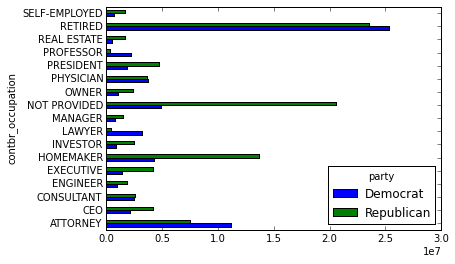

In [308]:
over_2mm.plot(kind='barh')

In [323]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.order(ascending=False)[:n]

In [324]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation
Obama, Barack  RETIRED              25305116.38
               ATTORNEY             11141982.97
               NOT PROVIDED          4866973.96
               HOMEMAKER             4248875.80
               PHYSICIAN             3735124.94
               LAWYER                3160478.87
               CONSULTANT            2459912.71
Romney, Mitt   RETIRED              11508473.59
               NOT PROVIDED         11396894.84
               HOMEMAKER             8147446.22
               ATTORNEY              5364718.82
               PRESIDENT             2491244.89
               CEO                   2324297.03
               EXECUTIVE             2300947.03
Name: contb_receipt_amt, dtype: float64

In [325]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer   
Obama, Barack  RETIRED               22694358.85
               SELF-EMPLOYED         18626807.16
               NOT EMPLOYED           8624567.10
               NOT PROVIDED           5053480.37
               HOMEMAKER              2605408.54
               STUDENT                 318831.45
               VOLUNTEER               257104.00
               MICROSOFT               215585.36
               SIDLEY AUSTIN LLP       168254.00
               REFUSED                 149516.07
Romney, Mitt   NOT PROVIDED          12059527.24
               RETIRED               11506225.71
               HOMEMAKER              8147196.22
               SELF-EMPLOYED          7414115.22
               STUDENT                 496490.94
               CREDIT SUISSE           281150.00
               MORGAN STANLEY          267266.00
               GOLDMAN SACH & CO.      238250.00
               BARCLAYS CAPITAL        162750.00
               H.I.G. CAPITAL      

##Bucketing donation amounts

Discretize the contributor amounts into buckets by contribution size, because this is a 'useful way to analyze this data'.

In [328]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels.head()

411      (10, 100]
412    (100, 1000]
413    (100, 1000]
414      (10, 100]
415      (10, 100]
Name: contb_receipt_amt, dtype: category
Categories (8, object): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

Now, given the above defined buckets, we can group the data by name and bucket/bin label, to get a histogram by donation size.

In [329]:
grouped = fec_mrbo.groupby(['cand_nm',labels])
grouped.size().head()

cand_nm        contb_receipt_amt
Obama, Barack  (0, 1]                  493
               (1, 10]               40070
               (10, 100]            372280
               (100, 1000]          153991
               (1000, 10000]         22284
dtype: int64

In [332]:
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,NaN
"(1000000, 10000000]",4,NaN


Now, to see percentage of donations, by size.

In [335]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [337]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


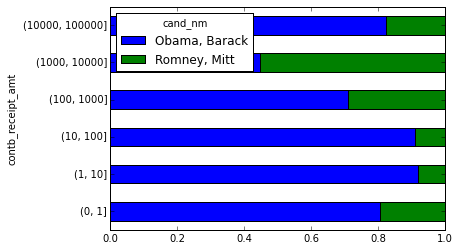

In [338]:
normed_sums[:-2].plot(kind='barh', stacked=True)
# exclude the two largest bins as they're not donations from indivs

##Donation stats by state

In [339]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [340]:
# get relative pct of total donations by state for each candidate
percent = totals.div(totals.sum(1), axis=0)
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224


And see the very end of chapter 9 for rough example code that draws the relative percentages on a US map.